# Quick recap

To get started, we need to make sure we have the right packages. The packages for surrogate construction and plotting is `tesuract` and `clif`. `tesuract` can be downloaded using `pip install tesuract` or getting the source from [here](https://github.com/kennychowdhary/tesuract). `clif` is a private repo and you should have got an invitation to be a collaborator. The link is [here](https://github.com/kennychowdhary/clif). We will use `clif` for plotting and some preprocessing transforms, but it is not required. 

These packages, and other will require the following third party libraries:

```
xarray
dask
numpy 
matplotlib
netcdf4
scikit-learn
cartopy (optional)
```

Once you have all those packages installed, we can begin loading and plotting the data. 

## Understanding the data

The data is saved as a netcdf file, which is similar to a pandas style data frame. We will load is as an xarray data set which will allow us to load a whole bunch of meta data along with the numpy arrays. For example, the data sets we will be looking at are latitude-longitude fields. If we were to import the data as a pure numpy array, we would lose the latitude or longitude indices associated with each row and column of the data set. xarray allows us to store that information. It is a mix between pandas and numpy, and it becoming increasingly utilized in the climate world. 

The data sets are broken up by seasons (DJF - December, January, February). So for DJF/ winter, we have two separate `*.nc` files or netcdf files. `lat_lon_10yr_24x48_DJF.nc` contains simulation data from 250 independent runs of E3SM. It contains different climatologies or outputs of the model such as shortwave and longwave cloud forcing, and total precipitation. Let's see how to load this data and what it looks like. 

In [1]:
import numpy as np
import xarray as xr
import dask

In [2]:
cd /Users/felixmeng/CME291/icme-xplore-bayes-spring22/src/data

/Users/felixmeng/CME291/icme-xplore-bayes-spring22/src/data


In [3]:
# open the data set and load it via chunks (dask) for efficient handling (optional)
season = 'DJF' # season
dataset = xr.open_mfdataset(f"../data/lat_lon_10yr_24x48_{season}.nc", chunks={'n': 1})

For our purposes, we will only need a few of these variables. The variables of interest will be 

```
SWCF (shortwave cloud forcing W/m^2)
LWCF (longwave cloud forcing W/m^2)
PRECT (total precipitation m/day)
area (latitude/ longitude area weights of grids, not equally spaced)
lhs (Latin hypercuve sampling tuning parameters/ feature space samples X)
lhs_bnds (bounds on feature space parameters - for re-scaling)
```

Let's extract the SWCF variable and the LHS points 

In [4]:
# Extract the training data for SWCF
Y = dataset['SWCF']
X = dataset['lhs']
X_bnds = dataset['lhs_bnds']

Now that we extracted the training data, let's explore its shape. The first dimension is always the sampling dimension, as standard in ML. Thus, each row of the dataset corresponds to a different sample

$X$ is of size $250 \times 5$ corresponding to $250$ training samples and $5$-dimensional feature space. Each row represents a different set of parameters and the corresponding E3SM model simulation output is given in $Y$. 

$Y$ is of size $250 \times 24 \times 48$, thus each sample of $Y$ is a $24\times48$ *image* or spatially varying latitude-longitude field. As you can see above, $Y$ is a three dimensional tensor (it's actually 4 but we ignore the time), with latitude and longitude coordinates. 

$(X,Y)$ represent input/ output pairs of the E3SM climate model. We will use this data to creat a regression model that maps/ interpolates $X$ to $Y$. We do this so we can calibrate the climate model, i.e., we want to find the optimal input value such that $Y$ matches some observed climate data. That is, 

$$x^* = \arg \min_{x} \|Y_{\mathrm{E^3SM}}(x) - Y_{\mathrm{obs}} \| $$

Since E3SM is too computationally expensive, instead, we solve 

$$x^* = \arg \min_{x} \|Y_{\mathrm{surrogate}}(x) - Y_{\mathrm{obs}} \| $$, 

where we replace the full model with a machine learning surrogate. This optimization can be solved quickly given that the surrogate is differentiable and easy to evaluate. 

This observed data can be loaded from the corresponding netcdf file from the same data directory.   

## Processing Data

In [5]:
# Load the observation or reference data
dataset_obs = xr.open_mfdataset(f"../data/lat_lon_24x48_{season}_obs.nc", chunks={'n': 1})
Y_obs = dataset_obs['SWCF']

In [6]:
Y_scalar=Y_obs.values.var()
Y_shift=Y_obs.values.mean()

## Creating a dummy predictor

Let's create our first surrogate which maps $X \mapsto Y$. The standard baseline or starting point would be to use a mean approximation as a model. Of course, this mean predictor has no dependence on $X$ but if it performs better than a more complex model, then it is a problem. So we always compute the dummy predictor as a default. 

We can use sklearn's dummy regressor to create such a model quite easily. For simplicity, it will help to flatten each of the $24\times 48$ output data sets. 

In [7]:
# Extract numpy array from the xarray.DataArray
Y_np = (Y.values-Y_obs.values)/np.sqrt(Y_scalar)
Y_np = np.array([Yi.flatten() for Yi in Y_np])
Y_np.shape

(250, 1152)

In [8]:
Y_np.mean(),Y_np.var()

(0.12064288, 0.089600556)

In [9]:
# Also, extract the feature matrix as a numpy array
X_np = X.values
X_np.shape

(250, 5)

If you take a look at $X$, it contains vastly different scales. For better performance, we will do some feature scaling and transform the input data to a standard input. We will use tesuract to perform this transformation. To do this we need to extract the bounds from the dataset and then perform a feature transform. 

In [10]:
feature_coords = dataset['x'].values
print("names of the feature coordinates:\n",feature_coords)

feature_bounds = dataset['lhs_bnds'].values
print("List of upper and lower bounds:\n", list(feature_bounds))

from tesuract.preprocessing import DomainScaler
feature_transform = DomainScaler(
                dim=X_np.shape[1],
                input_range=list(feature_bounds),
                output_range=(-1,1),
                )
X_s = feature_transform.fit_transform(X_np)
print("Range of scaled features:({0:.3f},{1:.3f})".format(X_s.min(), X_s.max()))

names of the feature coordinates:
 ['ice_sed_ai' 'clubb_c1' 'clubb_gamma_coef' 'zmconv_tau' 'zmconv_dmpdz']
List of upper and lower bounds:
 [array([ 350., 1400.]), array([1., 5.]), array([0.1, 0.5]), array([ 1800., 14400.]), array([-0.002 , -0.0001])]
Range of scaled features:(-1.000,0.998)


## Establishing a baseline

Try creating a surrogate four different ways and computing the cross validation score (5-fold cross validation score) for each of the regressors. Note that the regressors below have the ability to create a multi-target model (we have 1,152 targets which correspond to 24x48 latitude and longitude points). Not all regressors can perform a multi-target regression. 

Once a baseline is established, we can start experimenting with different metrics, hyper-parameter optimization, and we can try our first fully connect neural network. We can initially try sklearn's basic MLP model, which can handle multi-target data, but then we will move to keras since it can handle convolutional nets and most custom solutions. 

In [11]:
import matplotlib.pyplot as plt

In [12]:
X = X_s.copy()
Y = Y_np.copy()

# calculate the cross validation score as well
from sklearn.model_selection import cross_val_score
# Now we can create a dummy predictor mapping X -> Y
from sklearn.dummy import DummyRegressor
dummyreg = DummyRegressor(strategy='mean')
cv_scores = cross_val_score(dummyreg,X,Y,scoring='neg_mean_squared_error')
print(cv_scores.mean())

# try k nearest neighbors
from sklearn.neighbors import KNeighborsRegressor
Knn= KNeighborsRegressor(n_neighbors=6)
Knn.fit(X,Y)
print(cross_val_score(Knn,X,Y,scoring='neg_mean_squared_error').mean())
# linear regression
from sklearn.linear_model import LinearRegression
Linear= LinearRegression()
Linear.fit(X,Y) 
print(cross_val_score(Linear,X,Y,scoring='neg_mean_squared_error').mean())
# from sklearn import svm
# SVM=svm.SVC(kernel='linear', C=1).fit(X, Y)

-0.024716158956289293
-0.005413386877626181
-0.006029308834992172


### Creating a custom estimator

We can create a custom estimator, e.g., from keras, and have it be compatible with sklearn's API simply by wrapping it using the BaseEstimator class. This is optional, but I am putting some pseudo code to explain how this can work. 

In [13]:
import sklearn
import tensorflow as tf

In [14]:
BaseEstimator=sklearn.base.BaseEstimator

In [15]:
X.shape

(250, 5)

In [16]:
Y.shape

(250, 1152)

### Cross Validation

In [17]:
index=np.random.choice(250,50)
X_test=X[index]
Y_test=Y[index]
Index_x_bool=np.array([True]*250)
Index_x_bool[index]=False
X_train=X[Index_x_bool]
Y_train=Y[Index_x_bool]

### Base Estimator

In [18]:
np.linalg.norm(Y,2)

157.60178

In [19]:
np.linalg.norm(X,2)

9.830090679491631

In [20]:
BaseEstimator=sklearn.base.BaseEstimator

### Neural Network

In [21]:
import tensorflow.keras.backend as kb
from tensorflow import keras

In [22]:
import tensorflow_addons as tfa
import keras_tuner as kt

In [23]:
def custom_loss(y_actual,y_pred):
    custom_loss=kb.square(y_actual-y_pred)
    return custom_loss

In [24]:
class KerasNeuralNetwork(BaseEstimator):
    def __init__(self,nlayers=2,depth=[100]):
        self.nlayers=nlayers
        self.depth=depth
        self.model=None
    def fit(self,X,y=None,**fit_params):
        '''
        create a sequentil neural network
        add layers and activations
        model = Sequential(...)
        model.fit(X,y)
        '''
        model=tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(100,activation=tf.nn.leaky_relu),
                                tf.keras.layers.Dense(400,activation=tf.nn.leaky_relu),
                                 tf.keras.layers.Dense(800,activation=tf.nn.leaky_relu),
                                tf.keras.layers.Dense(1152,activation=tf.nn.leaky_relu)])
        model.compile(optimizer=tf.optimizers.Adam(),loss=custom_loss,
             metrics=[ tf.keras.metrics.RootMeanSquaredError()])
        history=model.fit(X,y,epochs=100, callbacks=[callbacks])
        self.model=model
        return model,history
    def predict(self,X):
        '''
        model.predict(X)
        '''
        self.model.predict(X)
        return self.model.predict(X)

In [89]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get("loss")<0):
            print("\nLoss is lower than 100 so cancelling training!")
            self.model.stop_training = True
callbacks=myCallback()


In [90]:
Base=BaseEstimator()
ker=KerasNeuralNetwork(Base)
model,history=ker.fit(X_train,Y_train, callbacks=[callbacks])

Epoch 1/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0825 - root_mean_squared_error: 0.2873
Epoch 2/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 0.2073

2022-04-07 16:58:18.034515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 10ms/step - loss: 0.0343 - root_mean_squared_error: 0.1851
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0236 - root_mean_squared_error: 0.1537
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0172 - root_mean_squared_error: 0.1311
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0138 - root_mean_squared_error: 0.1176
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0111 - root_mean_squared_error: 0.1051
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0094 - root_mean_squared_error: 0.0970
Epoch 8/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0081 - root_mean_squared_error: 0.0900
Epoch 9/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846
Epoch 10/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807
Ep

In [91]:
history.history

{'loss': [0.08254110813140869,
  0.034278396517038345,
  0.023627281188964844,
  0.017198234796524048,
  0.013820922933518887,
  0.011051607318222523,
  0.009400610812008381,
  0.008100086823105812,
  0.007161371409893036,
  0.006509307771921158,
  0.005856912583112717,
  0.005426998715847731,
  0.005045854952186346,
  0.004718806128948927,
  0.0044440701603889465,
  0.004171470180153847,
  0.0038019760977476835,
  0.00351843424141407,
  0.003381422720849514,
  0.003274313174188137,
  0.0031648948788642883,
  0.003100341884419322,
  0.002977572614327073,
  0.0028576457407325506,
  0.00280185928568244,
  0.002752982545644045,
  0.002660872647538781,
  0.0026160574052482843,
  0.002560619032010436,
  0.0025381369050592184,
  0.0024789078161120415,
  0.002440663054585457,
  0.002399472752586007,
  0.002385431667789817,
  0.0023495531640946865,
  0.0023106844164431095,
  0.0022856639698147774,
  0.0022419074084609747,
  0.0022318342234939337,
  0.0022077548783272505,
  0.002177119022235274

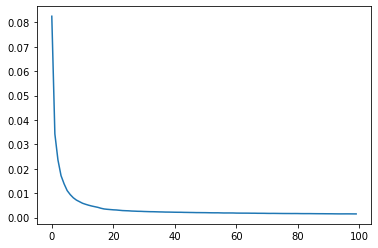

In [93]:
plt.plot(history.history["loss"])

In [94]:
model.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 15ms/step - loss: 0.0025 - root_mean_squared_error: 0.0497


2022-04-07 16:58:25.145216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.002474912442266941, 0.0497484914958477]

In [95]:
model.predict(X_test)

2022-04-07 16:58:25.861720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[ 0.13198361,  0.14812742,  0.15924132, ..., -0.00280328,
        -0.00182816, -0.00235879],
       [ 0.14286073,  0.16227432,  0.16570523, ..., -0.00498657,
        -0.00031762, -0.00083846],
       [ 0.13541332,  0.15535669,  0.14325131, ..., -0.00021752,
        -0.00125042, -0.00218423],
       ...,
       [ 0.13635568,  0.1501581 ,  0.15528344, ..., -0.00541278,
        -0.00335352, -0.00415948],
       [ 0.12727855,  0.1471924 ,  0.15583138, ..., -0.00229388,
        -0.00032134, -0.00188782],
       [ 0.13374414,  0.16081972,  0.1573657 , ..., -0.00469321,
        -0.00048604, -0.00361509]], dtype=float32)

In [96]:
cv_scores = cross_val_score(ker,X,Y,scoring='neg_root_mean_squared_error',cv=2)


Epoch 1/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0940 - root_mean_squared_error: 0.3066
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0578 - root_mean_squared_error: 0.2404
Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0371 - root_mean_squared_error: 0.1926
Epoch 4/100


2022-04-07 16:58:26.898827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 8ms/step - loss: 0.0265 - root_mean_squared_error: 0.1628
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0251 - root_mean_squared_error: 0.1584
Epoch 6/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0195 - root_mean_squared_error: 0.1397
Epoch 7/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0161 - root_mean_squared_error: 0.1268
Epoch 8/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0145 - root_mean_squared_error: 0.1205
Epoch 9/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0126 - root_mean_squared_error: 0.1124
Epoch 10/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0110 - root_mean_squared_error: 0.1050
Epoch 11/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0101 - root_mean_squared_error: 0.1005
Epoch 12/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960


2022-04-07 16:58:30.087020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 13ms/step - loss: 0.0950 - root_mean_squared_error: 0.3083
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0550 - root_mean_squared_error: 0.2345
Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0357 - root_mean_squared_error: 0.1889
Epoch 4/100
1/4 [======>.......................] - ETA: 0s - loss: 0.0246 - root_mean_squared_error: 0.1570

2022-04-07 16:58:30.311065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 7ms/step - loss: 0.0234 - root_mean_squared_error: 0.1531
Epoch 5/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509
Epoch 6/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333
Epoch 7/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0147 - root_mean_squared_error: 0.1211
Epoch 8/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0130 - root_mean_squared_error: 0.1140
Epoch 9/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0114 - root_mean_squared_error: 0.1069
Epoch 10/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0101 - root_mean_squared_error: 0.1006
Epoch 11/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964
Epoch 12/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0084 - root_mean_squared_error: 0.0918
E

2022-04-07 16:58:33.146227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [97]:
cv_scores.mean()

-0.04568123631179333

In [87]:
import xarray

/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/

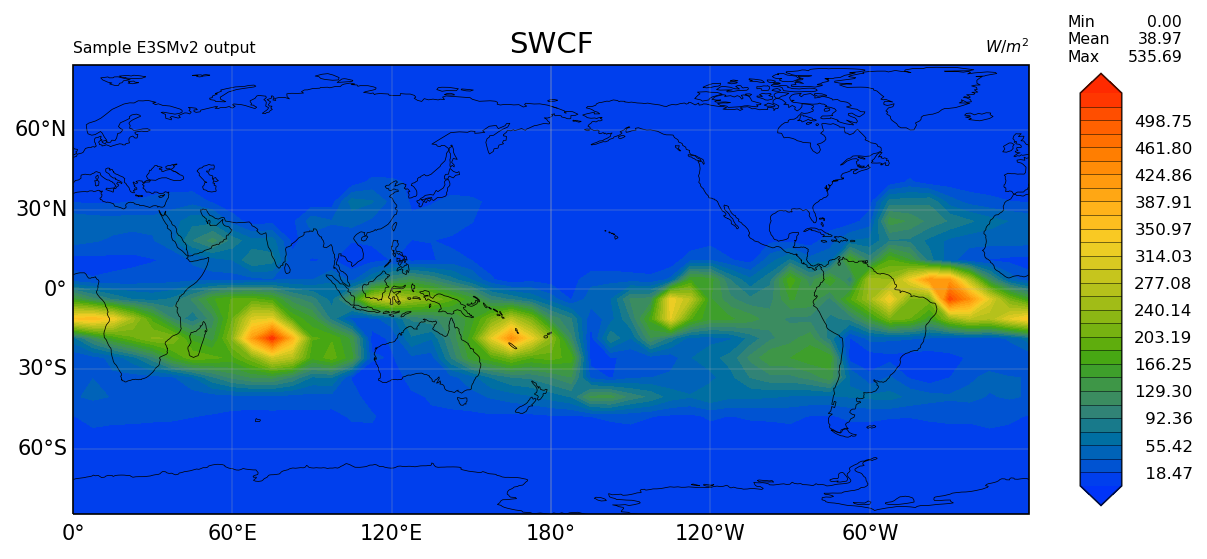

In [98]:
Y = dataset['SWCF']
X = dataset['lhs']
# import the lat lon contour plotting class
import clif
import clif.visualization as cviz
import matplotlib.pyplot as plt

# Now we initialize the contout.plot_lat_lon class with some parameters like the color map and titles
sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default",
    title="SWCF",
    rhs_title=r"$W/m^2$",
    lhs_title="Sample E3SMv2 output",
)
sample_plot.show(Y.var(axis=0))

## Bayesian Neural Network

In [49]:
import tensorflow_probability as tfp

In [50]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

In [51]:
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [54]:
def create_probablistic_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="relu",
        )(features)

Try batch normalization, nodes per layer
Automated way of producing the surrogate


List to try:
    Some of the elements in the field are just constant, we centered + shifted, center by subtracting the obs
    might don't need r^2
    Stick with negative root mean squared error
    keras tuner
    Bootstrap: use the original data too generate more data
    Batch Normalization
    Full keras model that have pca into it
    

R^2=0.624